# Stock Price Predicition for Infosys 

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Loading the model
We’ll use the close price for our forecasting models. Specifically, we will use historical closing prices in order to predict future ones. Close is the last price which was purchased on that day.

In [40]:
df = yf.download('INFY.NS', start = '2023-01-01', end = '2024-04-19')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,1514.000000,1526.500000,1504.050049,1524.000000,1484.572021,3801140
2023-01-03,1519.849976,1532.650024,1515.099976,1522.550049,1483.159668,4551130
2023-01-04,1521.000000,1521.000000,1491.099976,1494.800049,1456.127686,7059590
2023-01-05,1505.900024,1505.900024,1469.250000,1475.199951,1437.034546,9868404
2023-01-06,1470.000000,1475.000000,1446.500000,1448.500000,1411.025391,6443714
...,...,...,...,...,...,...
2024-04-10,1500.349976,1509.849976,1484.550049,1506.800049,1506.800049,6744595
2024-04-12,1504.000000,1506.800049,1479.500000,1484.750000,1484.750000,12275616
2024-04-15,1480.000000,1491.949951,1461.050049,1468.150024,1468.150024,8531224


<Axes: xlabel='Date', ylabel='Close'>

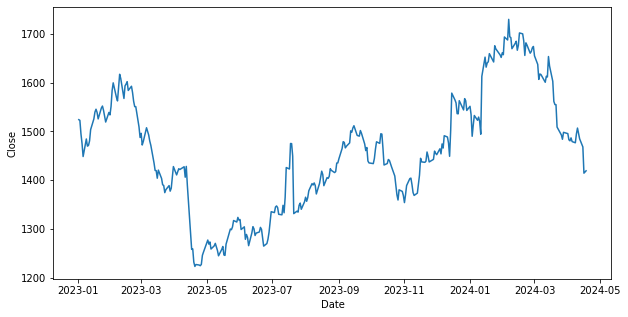

In [41]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df.index, y=df['Close'])

# Decomposition

It is a technique used to split the time series into categories.
In my data Trend is varing there is no constant mean and variance and also there is seasonality. 
Residual means the error in the data. 

The multiplicative component is used when the seasonal variation is proportional to the trend.

Text(0.5, 0.98, '\nMultiplicative Decompose')

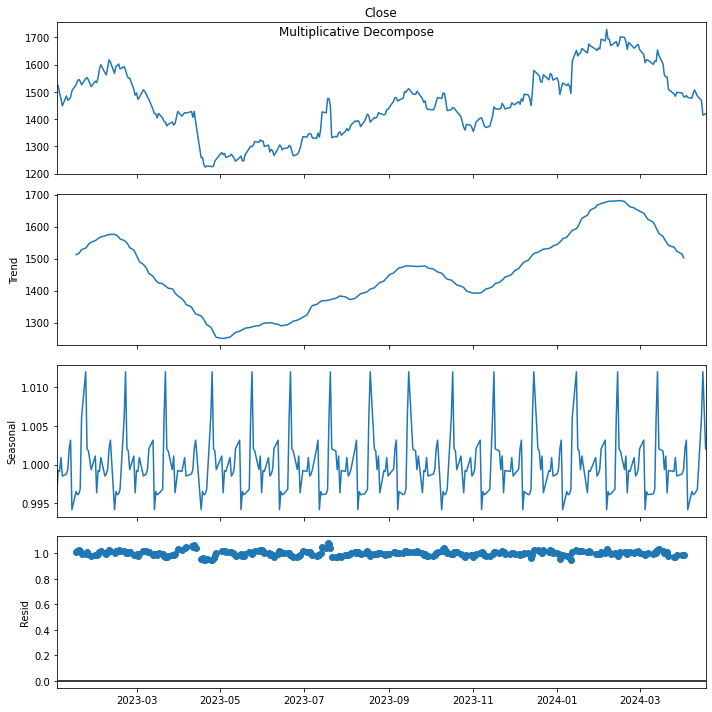

In [42]:
# Multiplicative Decompose
mul_result = seasonal_decompose(df['Close'], model = 'multiplicative', period=20)
plt.rcParams.update({'figure.figsize': (10,10)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

Additive decomposition is used when the seasonal variation is independent of the trend.

Text(0.5, 0.98, '\nAdditive Decompose')

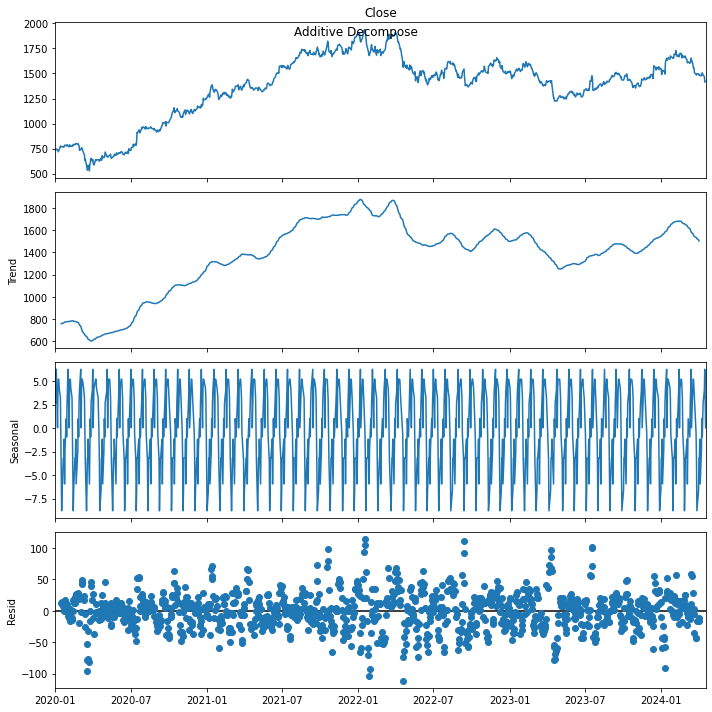

In [39]:
# Additive Decompose
add_result = seasonal_decompose(df['Close'], model = 'additive', period=20)
plt.rcParams.update({'figure.figsize': (10,10)})
add_result.plot().suptitle('\nAdditive Decompose', fontsize=12)

# Stationarity
A stationary time series is one that has constant mean, variance, and autocorrelation over time. There are several ways to check if a time series is stationary or not. One is to plot the series and look for visual clues, such as trends, cycles, or changes in variance. Another is to use statistical tests, such as the Augmented Dickey-Fuller (ADF) test and KPSS test

# ADF Test
One way to test whether a time series is stationary is to perform an Augmented Dickey-Fuller test, which uses the null and alternative hypotheses. If the p-value from the test is less than some significance level i.e., 5%, then we can reject the null hypothesis and conclude that the time series is stationary. If it's not stationary it means that the test has failed to reject the null hypothesis.

In [7]:
#ADF test
print('Null Hypothesis: Non Stationary')
addfuller_result = adfuller(df["Close"].values, autolag = 'AIC')
print(f'ADF Statistic: {addfuller_result[0]}')
print(f'p-value: {addfuller_result[1]}')
for key, value in addfuller_result[4].items():
    print('Critical Values: ')
    print(f'    {key}, {value}')
if (addfuller_result[1] < 0.05):
    print("Rejected the null hypothesis so time series is Stationary")
else:
    print('Failed to reject the null hypothesis so time series is Non Stationary')

Null Hypothesis: Non Stationary
ADF Statistic: -1.9957421195967309
p-value: 0.2884431464295072
Critical Values: 
    1%, -3.4365224825380714
Critical Values: 
    5%, -2.86426535058257
Critical Values: 
    10%, -2.568221078163292
Failed to reject the null hypothesis so time series is Non Stationary


# KPSS Test 
Another method to check if the time series is stationary is to perform KPSS test. So practically, the interpretaion of p-value is just the opposite to ADF test. That is, if p-value is < 0.05, then the series is non-stationary.

In [8]:
#KPSS test
print('Null Hypothesis: Stationary')
kpss_result = kpss(df["Close"], regression='c', nlags=None, store=False)
print(f'ADF Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
for key, value in kpss_result[3].items():
    print('Critical Values: ')
    print(f'    {key}, {value}')
if (kpss_result[1] <= 0.05):
    print("Rejected the null hypothesis so time series is Non Stationary")
else:
    print('Failed to reject the null hypothesis so time series is Stationary')

Null Hypothesis: Stationary
ADF Statistic: 2.5892894475696147
p-value: 0.01
Critical Values: 
    10%, 0.347
Critical Values: 
    5%, 0.463
Critical Values: 
    2.5%, 0.574
Critical Values: 
    1%, 0.739
Rejected the null hypothesis so time series is Non Stationary


<ipython-input-8-8b22dae82f71>:3: FutureWarning: None is not a valid value for nlags. It must be an integer, 'auto' or 'legacy'. None will raise starting in 0.14
  kpss_result = kpss(df["Close"], regression='c', nlags=None, store=False)
<ipython-input-8-8b22dae82f71>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df["Close"], regression='c', nlags=None, store=False)


# Differencing 
Differencing is a technique to transform a non-stationary time series into a stationary one. It involves subtracting the current value of the series from the previous one, or from a lagged value. Differencing can remove trends and seasonal patterns from the data, making it more stationary.

In [9]:
#Differencing
df["diff_1"] = df["Close"].diff(periods=1)
df["diff_2"] = df["Close"].diff(periods=2)
df

,Open,High,Low,Close,Adj Close,Volume,diff_1,diff_2
Date,,,,,,,,
2020-01-01,735.000000,740.000000,732.549988,736.849976,672.502625,2112415,NaN,NaN
2020-01-02,738.900024,740.799988,730.900024,734.700012,670.540466,5658200,-2.149963,NaN
2020-01-03,733.900024,748.000000,733.900024,746.000000,680.853699,7882938,11.299988,9.150024
2020-01-06,746.099976,753.799988,736.500000,738.849976,674.328064,6519403,-7.150024,4.149963
2020-01-07,738.000000,742.599976,725.099976,727.900024,664.334351,7899363,-10.949951,-18.099976
...,...,...,...,...,...,...,...,...
2024-04-10,1500.349976,1509.849976,1484.550049,1506.800049,1506.800049,6744595,11.950073,30.100098
2024-04-12,1504.000000,1506.800049,1479.500000,1484.750000,1484.750000,12275616,-22.050049,-10.099976
2024-04-15,1480.000000,1491.949951,1461.050049,1468.150024,1468.150024,8531224,-16.599976,-38.650024


In [10]:
#adfuller test
results = adfuller(df["diff_1"].dropna())
if (results[1] <= 0.05):
    print("Stationary")
else:
    print("Not stationary")
results[1]

Stationary


0.0

In [11]:
#kpss test
results = kpss(df["diff_1"].dropna())
if (results[1] <= 0.05):
    print("stationary")
else:
    print("stationary")
results[1]

stationary


<ipython-input-11-9d29acb7c647>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  results = kpss(df["diff_1"].dropna())


0.1

In [12]:
df1 = df["diff_1"].dropna()
df1

Date
2020-01-02    -2.149963
2020-01-03    11.299988
2020-01-06    -7.150024
2020-01-07   -10.949951
2020-01-08    -9.700012
                ...    
2024-04-10    11.950073
2024-04-12   -22.050049
2024-04-15   -16.599976
2024-04-16   -53.700073
2024-04-18     4.800049
Name: diff_1, Length: 1063, dtype: float64

# Interpreting ACF and PACF
The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. The autocorrelation analysis helps to identify the AR(p) and MA(q) parameters for the ARIMA model.

### PACF
A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

### ACF
The correlation of the time series observations is calculated with values of the same series at previous times autocorrelation.

<Figure size 360x216 with 0 Axes>

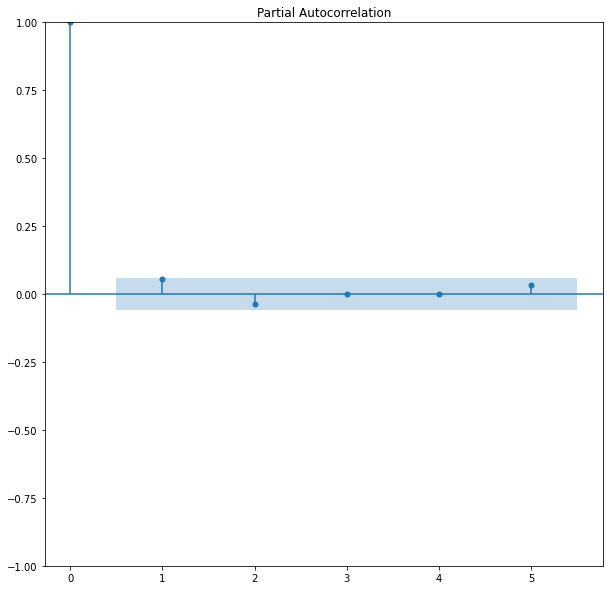

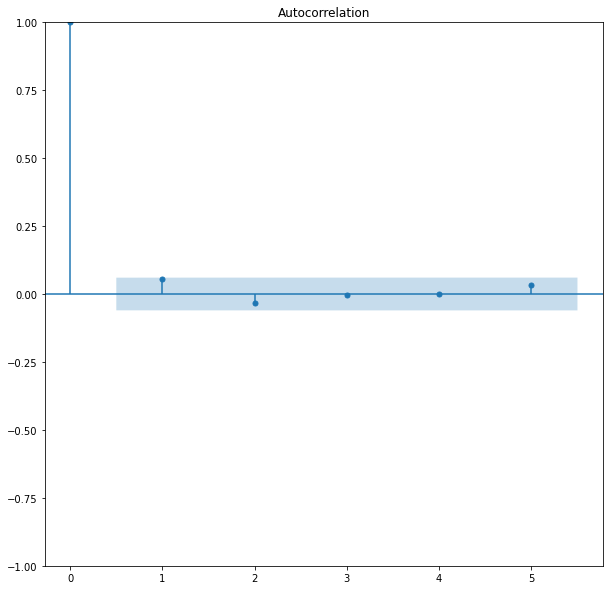

In [13]:
plt.figure(figsize=(5,3))
pacf = plot_pacf(df1, lags = 5)
acf = plot_acf(df1, lags = 5)

# Split the time series into test and train

In [14]:
# train test split
to_row = int(len(df['Close'])*0.9)
train = list(df1[0:to_row])
test = list(df1[to_row:])

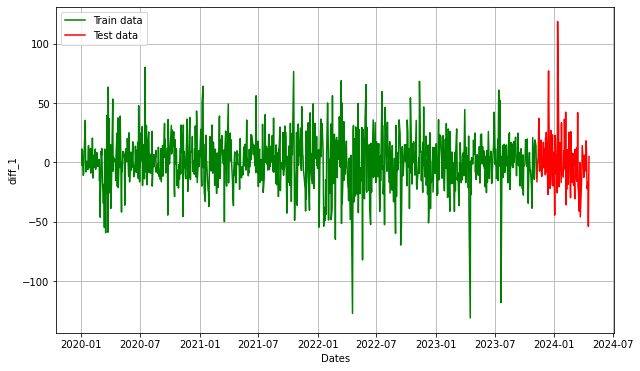

In [15]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('diff_1')
plt.plot(df1[0:to_row], 'green', label = 'Train data')
plt.plot(df1[to_row:], 'red', label = 'Test data')
plt.legend()

# Importing ARIMA model 

In [16]:
train_data, test_data = df['diff_1'][0:int(len(df1)*0.9)], df1[int(len(df1)*0.9):]

history = [x for x in train_data]
y = test_data
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,1))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  956
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4324.817
Date:                Thu, 18 Apr 2024   AIC                           8655.634
Time:                        19:25:28   BIC                           8670.219
Sample:                             0   HQIC                          8661.190
                                - 956                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0597      0.027      2.217      0.027       0.007       0.113
ma.L1         -0.9973      0.004   -245.327      0.000      -1.005      -0.989
sigma2       496.2562     14.470     34.296      0.000     467.896     524.616
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               494.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.51
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As seen above, the model summary provides several statistical measures to evaluate the performance of ARIMA model in Python. Moreover, we also know the coefficient values for each of the parameters. As we kept the value of the MA parameter or “q” as 1, we have one trained coefficients for MA and one for AR.

Other than that we see the scores such as Akaike Information Critera (AIC), Bayesian Information Criterion (BIC), Hannan-Quinn Information Criterion (HQIC), and the standard deviation of innovations (innovations are the difference of the real value at time t and the predicted value at that time).

In a rolling forecast, the model is often retrained as new data becomes available, allowing for more accurate and adaptive predictions.

In [17]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1062
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4813.945
Date:                Thu, 18 Apr 2024   AIC                           9633.890
Time:                        19:25:49   BIC                           9648.791
Sample:                             0   HQIC                          9639.538
                               - 1062                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0569      0.025      2.245      0.025       0.007       0.107
ma.L1         -0.9977      0.004   -250.898      0.000      -1.005      -0.990
sigma2       505.2808     13.342     37.873      0.000     479.132     531.430
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               589.79
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 584.9870494965932
MAE: 17.59205071158517
RMSE: 24.186505524705158


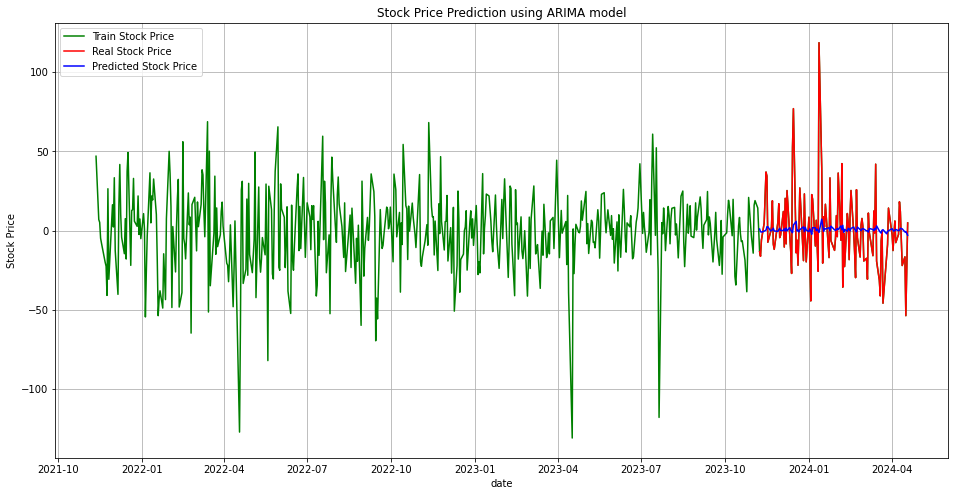

In [19]:
plt.figure(figsize=(16,8))
plt.plot(df1.index[-600:], df1.tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction using ARIMA model')
plt.xlabel('date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
arima = ARIMA(df['Close'], order=(2,1,2))
arima_predict = arima.fit()
forecast = arima_predict.forecast(steps=30)
#forecast

C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be g

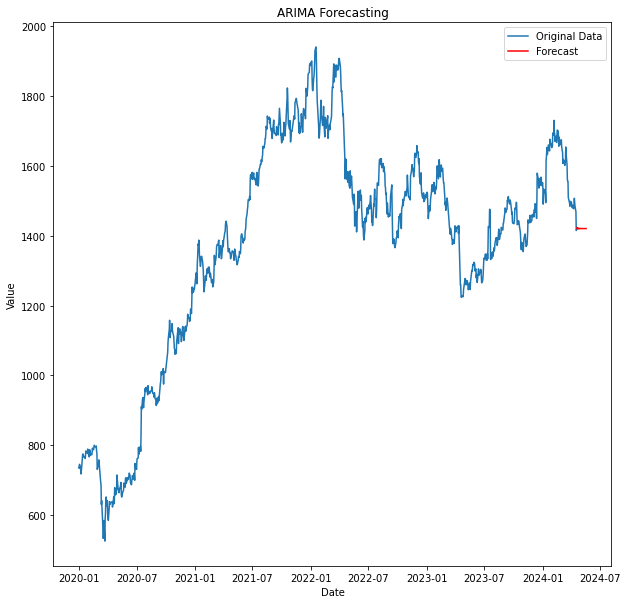

In [21]:
# Plot original data
plt.plot(df.index, df['Close'], label='Original Data')
 
# Plot forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=30, freq='D')  # Assuming daily frequency
plt.plot(forecast_index, forecast, color='red', label='Forecast')
 
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecasting')
plt.legend()
plt.show()

# Importing SARIMA model 

In [22]:
train_data, test_data = df['diff_1'][0:int(len(df1)*0.9)], df1[int(len(df1)*0.9):]

history = [train for train in train_data]
test = test_data
# make first prediction
sarima_predictions = list()
sarima_model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = sarima_model.fit()
yhat = model_fit.forecast(30)[0]
sarima_predictions.append(yhat)
history.append(test[0])
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  956
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4299.285
Date:                            Thu, 18 Apr 2024   AIC                           8608.569
Time:                                    19:25:54   BIC                           8632.814
Sample:                                         0   HQIC                          8617.810
                                            - 956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0608      0.028      2.195      0.028       0.007       0.115
ma.L1         -0.9997      0.117     -8.550      0.000      -1.229      -0.771
ar.S.L12       0.0434      0.033      1.330      0.183      -0.021       0.107
ma.S.L12      -0.9998      1.828     -0.547      0.584      -4.582       2.582
sigma2       495.8332    900.018      0.551      0.582   -1268.170    2259.837
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               447.92
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.44
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# rolling forecasts
for i in range(1, len(test)):
    # predict
    sarima_model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = sarima_model.fit()
    yhat = model_fit.forecast(30)[0]
    # invert transformed prediction
    sarima_predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1062
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4786.575
Date:                            Thu, 18 Apr 2024   AIC                           9583.150
Time:                                    19:31:07   BIC                           9607.928
Sample:                                         0   HQIC                          9592.546
                                           - 1062                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0608      0.026      2.346      0.019       0.010       0.112
ma.L1         -0.9998      0.111     -9.019      0.000      -1.217      -0.783
ar.S.L12       0.0486      0.031      1.555      0.120      -0.013       0.110
ma.S.L12      -0.9998      1.845     -0.542      0.588      -4.616       2.616
sigma2       503.2850    922.513      0.546      0.585   -1304.808    2311.378
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               531.11
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

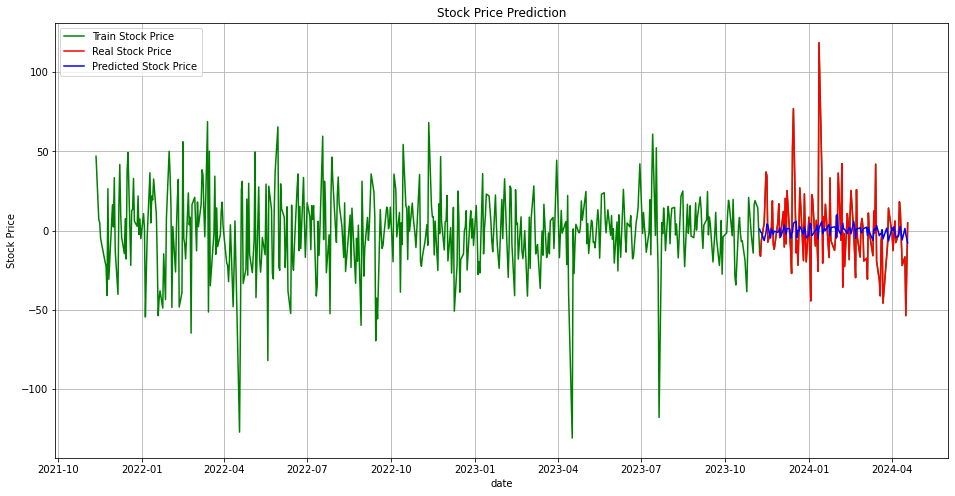

In [24]:
plt.figure(figsize=(16,8))
plt.plot(df1.index[-600:], df1.tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, sarima_predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# report performance
mse = mean_squared_error(test, sarima_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, sarima_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, sarima_predictions))
print('RMSE: '+str(rmse))

MSE: 569.8819973699068
MAE: 17.429564548348836
RMSE: 23.87220135157013


# Forecasting for next 30 days

In [27]:
sarima = SARIMAX(df['Close'], order=(1,1,1),
                seasonal_order=(1,1,0,12))
sarima_predict = sarima.fit()
sarima_forecast = sarima_predict.forecast(steps=30)
sarima_forecast

C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\syadav18\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in

1064    1424.392817
1065    1416.421588
1066    1433.898160
1067    1428.660592
1068    1410.508091
1069    1390.859334
1070    1398.052205
1071    1404.578994
1072    1371.949376
1073    1355.527215
1074    1321.786191
1075    1330.764757
1076    1332.465678
1077    1322.436869
1078    1331.166794
1079    1330.946766
1080    1317.485094
1081    1305.503778
1082    1317.567345
1083    1326.504903
1084    1298.578136
1085    1282.076932
1086    1239.463672
1087    1246.584796
1088    1249.815715
1089    1240.701546
1090    1253.319547
1091    1250.869113
1092    1235.322264
1093    1219.932602
Name: predicted_mean, dtype: float64

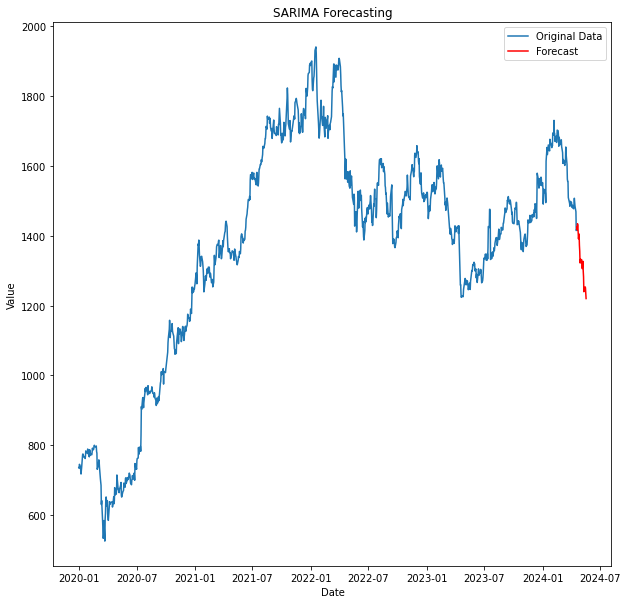

In [28]:
# Plot original data
# plt.figure(figsize)
plt.plot(df.index, df['Close'], label='Original Data')
 
# Plot forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=30, freq='D')  # Assuming daily frequency
plt.plot(forecast_index, sarima_forecast, color='red', label='Forecast')
 
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecasting')
plt.legend()
plt.show()